# Basic example for bssunfold package

In [1]:
# %pip install bssunfold pandas numpy matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bssunfold import Detector
import seaborn as sns

## Load the response functions file for the BSS
- first column: Energy in MeV
- other columns: detector responses for the set of moderator spheres

In [3]:
# response functions default GSF
from bssunfold import RF_GSF
df = pd.DataFrame.from_dict(RF_GSF, orient='columns')
Detector_GSF = Detector(df)

In [4]:
# reference spectrum ISO Cf-252.
reference_spectrum = {
    "E_MeV": [
        1e-09,
        1.5848931924611136e-09,
        2.5118864315095803e-09,
        3.981071705534973e-09,
        6.309573444801934e-09,
        1e-08,
        1.5848931924611143e-08,
        2.511886431509581e-08,
        3.9810717055349736e-08,
        6.309573444801934e-08,
        1.0000000000000001e-07,
        1.5848931924611143e-07,
        2.5118864315095823e-07,
        3.9810717055349735e-07,
        6.309573444801937e-07,
        1.0000000000000002e-06,
        1.584893192461114e-06,
        2.5118864315095823e-06,
        3.981071705534973e-06,
        6.309573444801937e-06,
        1e-05,
        1.584893192461114e-05,
        2.5118864315095822e-05,
        3.9810717055349776e-05,
        6.309573444801943e-05,
        0.0001,
        0.00015848931924611142,
        0.0002511886431509582,
        0.0003981071705534978,
        0.0006309573444801943,
        0.001,
        0.0015848931924611143,
        0.0025118864315095825,
        0.003981071705534978,
        0.006309573444801942,
        0.01,
        0.01584893192461114,
        0.025118864315095826,
        0.039810717055349776,
        0.06309573444801943,
        0.1,
        0.15848931924611173,
        0.25118864315095824,
        0.3981071705534969,
        0.6309573444801944,
        1.0,
        1.5848931924611174,
        2.5118864315095824,
        3.9810717055349856,
        6.309573444801943,
        10.0,
        15.848931924611176,
        25.118864315095824,
        39.810717055349855,
        63.09573444801943,
        100.0,
        158.48931924611173,
        251.18864315095823,
        398.1071705534986,
        630.9573444801944,
    ],
    "Phi": [
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0002193244132568562,
        0.000922,
        0.0017977302145640818,
        0.0033934229230273556,
        0.00638236969883396,
        0.01212580290671056,
        0.0237,
        0.04468185467401807,
        0.0822779218679577,
        0.1450462719353082,
        0.2413649401952857,
        0.359,
        0.45221093414611185,
        0.4338707690763234,
        0.2708850368693928,
        0.0856762250762,
        0.00427,
        0.0004258199483775139,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
    ],
}

In [5]:
# effective readings of the GSF BSS for the reference spectrum [reading per second]
readings = {
    "0in": 0.00037,
    "2in": 0.00999,
    "3in": 0.05366,
    "5in": 0.18417,
    "6in": 0.21968,
    "8in": 0.22007,
    "10in": 0.17214,
    "12in": 0.12033,
    "15in": 0.06674,
    "18in": 0.03411,
}

## Unfold the spectrum
1) Tikhonov regularization solded with CVXPY, ECOS solver
2) Landweber iterative unfolding
3) CVXPY results are used as initial guess for Landweber unfolding

In [6]:
result_cvxpy = Detector_GSF.unfold_cvxpy(readings, regularization=1e-4)

results = {
    "CVXPY": result_cvxpy,
    "CVXPY[ECOS]": Detector_GSF.unfold_cvxpy(
        readings, regularization=1e-4, solver="ECOS"
    ),
    "Landweber": Detector_GSF.unfold_landweber(readings, max_iterations=3000),
    "CVXPY -> Landweber": Detector_GSF.unfold_landweber(
        readings, initial_spectrum=result_cvxpy["spectrum"], max_iterations=3000
    ),
}

Status: optimal
Objective value: 8.30923138966197e-05
Residual norm: 0.000000
Result saved with key: 20260116_164231_cvxpy
Status: optimal
Objective value: 8.308965699210048e-05
Residual norm: 0.000000
Result saved with key: 20260116_164231_cvxpy
Result saved with key: 20260116_164231_Landweber
Result saved with key: 20260116_164231_Landweber


# Unfolding with uncertainty

In [15]:
# Unfold spectrum with uncertainty calculation based on Monte-Carlo
#1 CVXPY
result_cvxpy_unc = Detector_GSF.unfold_cvxpy(
    readings, regularization=1e-4, calculate_errors=True
)
#2 Landweber
result_landweber_unc = Detector_GSF.unfold_landweber(
    readings, calculate_errors=True
)
#3 CVXPY -> Landweber
result_cvxpy_landweber_unc = Detector_GSF.unfold_landweber(
    readings,
    initial_spectrum=result_cvxpy_unc["spectrum"],
    max_iterations=3000,
    calculate_errors=True,
)

Status: optimal
Objective value: 8.30923138966197e-05
Residual norm: 0.000000
Calculating uncertainty with Monte-Carlo...
Status: optimal
Objective value: 0.0009121666396457591
Status: optimal
Objective value: 0.001959601900641453
Status: optimal
Objective value: 0.0026634091405251833
Status: optimal
Objective value: 0.0031872329073719375
Status: optimal
Objective value: 0.00015857388062004134
Status: optimal
Objective value: 0.000820162863739015
Status: optimal
Objective value: 0.002690918441305844
Status: optimal
Objective value: 9.188274262344824e-05
Status: optimal
Objective value: 0.0009657973463093353
Status: optimal
Objective value: 0.0016001092308897391
Status: optimal
Objective value: 0.0018719308679775806
Status: optimal
Objective value: 0.00010665024534062816
Status: optimal
Objective value: 0.0025508728775157303
Status: optimal
Objective value: 0.0017903387610030102
Status: optimal
Objective value: 0.0016509782277837808
Status: optimal
Objective value: 0.0015465615574870347

# Plot spectra with uncertanity

- use of Landweber iterations to stabilize the solution from CVXPY

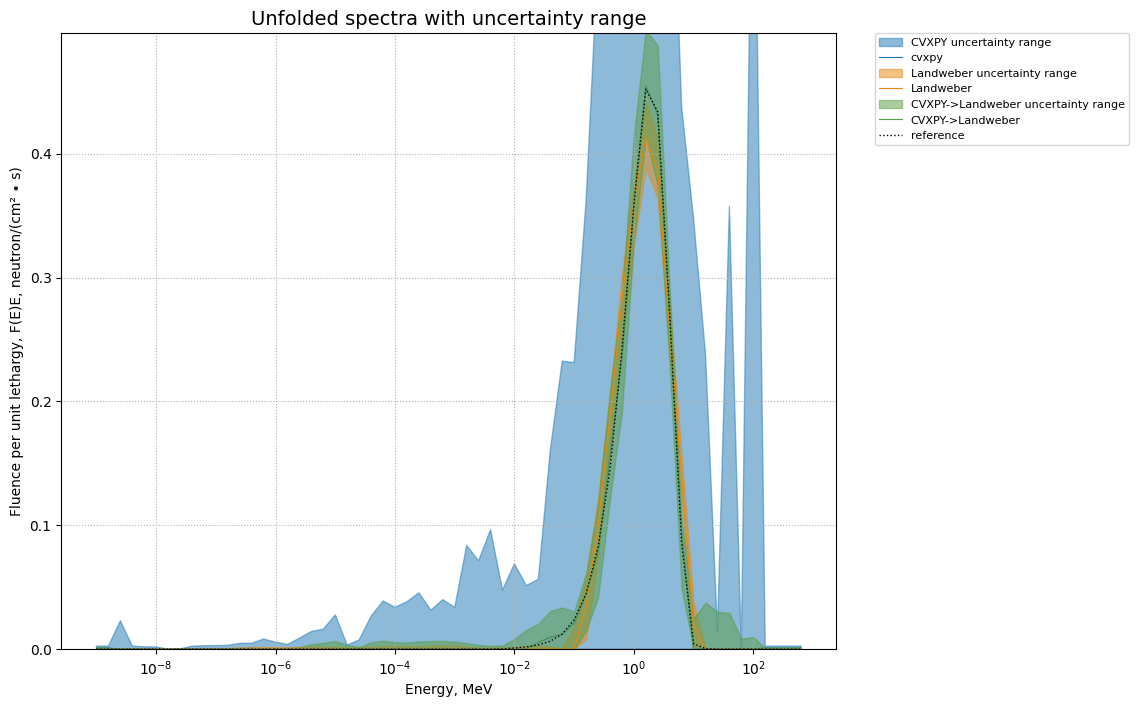

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
methods = list(results.keys())
all_labels = ["reference"] + methods

colors = ["black", "#1f77b4", "#e68910", "#589c43", "indianred"]
# Первый график (спектры)

ax.fill_between(
    result_cvxpy_unc["energy"],
    result_cvxpy_unc["spectrum_uncert_min"],
    result_cvxpy_unc["spectrum_uncert_max"],
    alpha=0.5,
    color=colors[1],
    label="CVXPY uncertainty range",
)

ax.plot(
    result_cvxpy_unc["energy"],
    result_cvxpy_unc["spectrum"],
    label="cvxpy",
    color=colors[1],
    ls="-",
    linewidth=0.8,
    alpha=1,
)

ax.fill_between(
    result_landweber_unc["energy"],
    result_landweber_unc["spectrum_uncert_min"],
    result_landweber_unc["spectrum_uncert_max"],
    alpha=0.5,
    color=colors[2],
    label="Landweber uncertainty range",
)

ax.plot(
    result_landweber_unc["energy"],
    result_landweber_unc["spectrum"],
    label="Landweber",
    color=colors[2],
    ls="-",
    linewidth=0.8,
    alpha=1,
)

# CVXPY -> Landweber
ax.fill_between(
    result_cvxpy_landweber_unc["energy"],
    result_cvxpy_landweber_unc["spectrum_uncert_min"],
    result_cvxpy_landweber_unc["spectrum_uncert_max"],
    alpha=0.5,
    color=colors[3],
    label="CVXPY->Landweber uncertainty range",
)

ax.plot(
    result_cvxpy_landweber_unc["energy"],
    result_cvxpy_landweber_unc["spectrum"],
    label="CVXPY->Landweber",
    color=colors[3],
    ls="-",
    linewidth=0.8,
    alpha=1,
)



ax.plot(
    reference_spectrum["E_MeV"],
    reference_spectrum["Phi"],
    label="reference",
    linewidth=1,
    linestyle=":",
    color=colors[0],
)

ax.set_xlabel("Energy, MeV")
ax.set_ylabel("Fluence per unit lethargy, F(E)E, neutron/(cm² ∙ s)")
ax.set_xscale("log")
ax.set_ylim(0,np.max(reference_spectrum["Phi"])*1.1)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0, fontsize=8)
ax.grid(True, which="both", ls=":")
ax.set_title(f"Unfolded spectra with uncertainty range", fontsize=14)
plt.show()

# Barplot with uncertainty

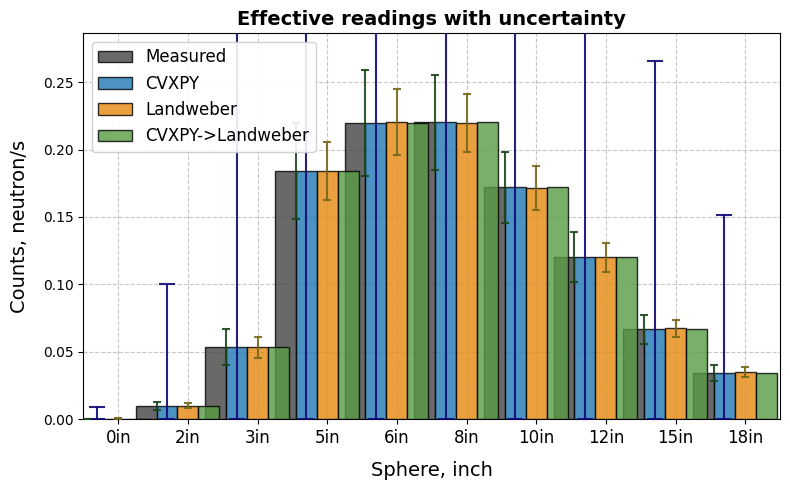

In [ ]:
# Data fro barplot
categories = list(readings.keys())
ref_values = [readings[cat] for cat in categories] # reference original measurements

#uncertainty CVXPY
eff_readings_cvxpy = result_cvxpy_unc["effective_readings"]
cvxpy_values = [eff_readings_cvxpy[cat] for cat in categories]
yerr_min_cvxpy = Detector_GSF.Amat.T @ result_cvxpy_unc['spectrum_uncert_min']
yerr_max_cvxpy = Detector_GSF.Amat.T @ result_cvxpy_unc['spectrum_uncert_max']
yerr_lower_cvxpy = [cvxpy_values[i] - yerr_min_cvxpy[i] for i in range(len(cvxpy_values))]
yerr_upper_cvxpy = [yerr_max_cvxpy[i] - cvxpy_values[i] for i in range(len(cvxpy_values))]

#uncertainty Landwever
eff_readings_landweber = result_landweber_unc["effective_readings"]
landweber_values = [eff_readings_landweber[cat] for cat in categories]
yerr_min_lw = Detector_GSF.Amat.T @ result_landweber_unc['spectrum_uncert_min']
yerr_max_lw = Detector_GSF.Amat.T @ result_landweber_unc['spectrum_uncert_max']
yerr_lower_lw = [landweber_values[i] - yerr_min_lw[i] for i in range(len(landweber_values))]
yerr_upper_lw = [yerr_max_lw[i] - landweber_values[i] for i in range(len(landweber_values))]


#uncertainty CVXPY -> Landwever
eff_readings_cvxpy_landweber = result_cvxpy_landweber_unc["effective_readings"]
cvxpy_landweber_values = [eff_readings_cvxpy_landweber[cat] for cat in categories]
yerr_min_clw = Detector_GSF.Amat.T @ result_cvxpy_landweber_unc['spectrum_uncert_min']
yerr_max_clw = Detector_GSF.Amat.T @ result_cvxpy_landweber_unc['spectrum_uncert_max']
yerr_lower_clw = [cvxpy_landweber_values[i] - yerr_min_clw[i] for i in range(len(cvxpy_landweber_values))]
yerr_upper_clw = [yerr_max_clw[i] - cvxpy_landweber_values[i] for i in range(len(cvxpy_landweber_values))]

# Настройки графика
plt.figure(figsize=(8, 5))

# Позиции столбцов на оси X
x_pos = np.arange(len(categories))
width = 0.3  # Ширина столбцов
n_bars = len(categories)

# Создаем столбцы референтных значений
bars_ref = plt.bar(x_pos + (- n_bars / 4 + 0.5) * width, ref_values, width,
                   label='Measured',
                   color="#434443", 
                   edgecolor='black',
                   alpha=0.8,
                   zorder=3)


# Bars for CVXPY 
bars_cvxpy = plt.bar(x_pos + (1- n_bars / 4 + 0.5) * width, cvxpy_values, width,
                     label='CVXPY',
                     color='#1f77b4',  # синий
                     edgecolor='black',
                     alpha=0.8,
                     zorder=3)

# Uncertainty for CVXPY
plt.errorbar(x_pos + (1- n_bars / 4 + 0.5) * width, cvxpy_values,
             yerr=[yerr_lower_cvxpy, yerr_upper_cvxpy], 
             fmt='none',  
             ecolor="#0f0875", 
             elinewidth=1.5, 
             capsize=6,  
             capthick=1.5,  
             alpha=0.9,
             zorder=4,
            )

#-------------------------------------------------------------------
# Bars for Landweber 
bars_lw = plt.bar(x_pos +(2 - n_bars / 4 + 0.5) * width, landweber_values, width,
                     label='Landweber',
                     color="#e68910",
                     edgecolor='black',
                     alpha=0.8,
                     zorder=3)

# Uncertainty for Landweber
plt.errorbar(x_pos + (2 - n_bars / 4 + 0.5) * width , landweber_values,
             yerr=[yerr_lower_lw, yerr_lower_lw],  #
             fmt='none',  
             ecolor="#75681b",  
             elinewidth=1.5,  
             capsize=3,  
             capthick=1.5,  
             alpha=0.9,
             zorder=4,
            )

#-------------------------------------------------------------------
# Bars for CVXPY->Landweber 
bars_lw = plt.bar(x_pos + (3- n_bars / 4 + 0.5) *2* width, cvxpy_landweber_values, width,
                     label='CVXPY->Landweber',
                     color="#589c43",
                     edgecolor='black',
                     alpha=0.8,
                     zorder=3)

# Uncertainty for CVXPY->Landweber
plt.errorbar(x_pos + (3 - n_bars / 2 + 0.5) * 2*width , cvxpy_landweber_values,
             yerr=[yerr_lower_clw, yerr_lower_clw],  # Асимметричные погрешности
             fmt='none',  # без маркеров, только линии погрешностей
             ecolor="#1b461a",  # красный цвет для погрешностей
             elinewidth=1.5,  # толщина линий погрешностей
             capsize=3,  # размер горизонтальных черточек
             capthick=1.5,  # толщина горизонтальных черточек
             alpha=0.9,
             zorder=4,
            )


# Настройка осей и заголовка
plt.title('Effective readings with uncertainty', 
          fontsize=14, fontweight='bold')
plt.xlabel('Sphere, inch', fontsize=14, labelpad=10)
plt.ylabel('Counts, neutron/s', fontsize=14, labelpad=10)

# Настройка оси X
plt.xticks(x_pos, categories, fontsize=12)
plt.xlim(-0.5, len(categories) - 0.5)
plt.ylim(0, max(ref_values) * 1.3)
# Добавление сетки
plt.grid(True, which='both', alpha=0.7, linestyle='--', zorder=0)
plt.grid(True, which='minor', alpha=0.7, linestyle=':', zorder=0)

# Легенда
plt.legend(fontsize=12, loc='upper left', framealpha=0.9)

plt.tight_layout()
# Показать график
plt.show()